In [1]:
from fastai2.basics import *
from fastai2.vision.all import *
from pathlib import Path

from mish_cuda import MishCuda
import cmasher as cmr
import gc
import scipy.cluster.hierarchy as hcluster

from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, roc_curve
PATH = Path('../..').resolve()

seed = 256

In [2]:
import sys
PATH = Path('../..').resolve()
sys.path.append(f'{PATH}/src')

from utils import *
metrics = [accuracy, F1Score(), Recall(), Precision()]

import sys
sys.path.append('/home/jupyter/morphological-spectra/src')
from xresnet_deconv import *


# Look around...

In [2]:
df = pd.read_csv(PATH/'data/desi-sv.csv')
df.sample(5)

,OBJID,RA,DEC,r_mag,saga_p1_cut,saga_p2_cut
606638,905019800000002242,24.046801,31.262535,19.166084,True,False
185932,903355600000004023,218.170739,0.657705,21.873453,True,False
732764,915804390000000143,119.630781,48.953782,21.333872,True,False
650040,915133990000000838,154.653592,33.393085,21.212330,True,True
28093,903018510000005716,65.635739,-4.876726,21.636305,True,False


In [9]:
df.saga_p1_cut.sum(), df.saga_p2_cut.sum()

(860904, 88428)

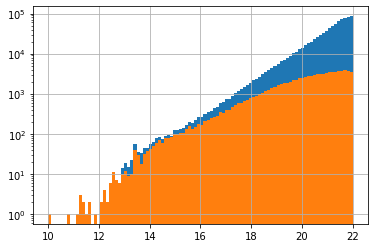

In [6]:
df.r_mag.hist(bins=100, range=[10, 22], log=True)
df[df.saga_p2_cut].r_mag.hist(bins=100, range=[10, 22], log=True)

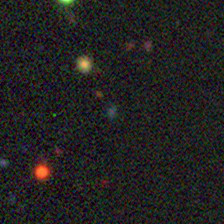

In [10]:
# currently we only have P2 cut images
PILImage.create(f'{PATH}/images-legacy_desi-sv/915133990000000838.jpg')

# Training models at 112 pixels for prediction

In [3]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-11.csv', dtype={'OBJID': str})

df = saga.sample(frac=1).copy()
df['lower_z'] = df.SPEC_Z < 0.02
df['low_z'] = df.SPEC_Z < 0.03

# in order to use with previous utils
df['SPEC_FLAG'] = 1

In [9]:

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(224)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)
seed = 256


def oversample(df: pd.DataFrame, num_oversample=None, label_column='lower_z'):
    """Oversample a `pd.DataFrame` such that `label_column` classes
    are balanced. Note that the result is not shuffled.
    """
    lst = [df]
    N_majority = (~df[label_column]).sum()
    N_minority = ( df[label_column]).sum()
    
    try:
        # -1 -> rebalance casses, other negative numbers will raise a ValueError
        if num_oversample == -1: num_oversample = N_majority - N_minority
        lst.append(df[df[label_column]].sample(num_oversample, replace=True))
    except ValueError:
        print('Make sure that `num_oversample` is larger than the number of objects in the label class')

    return pd.concat(lst)

def oversample_with_magnitude(
    df: pd.DataFrame, 
    num_oversample=None, 
    magnitude_column='r_mag', 
    label_column='lower_z'
):
    """Oversample a `pd.DataFrame` as a function of magnitude.
    """
    lst = [df]
    
    for r2 in np.arange(18, 22., 0.25):
        r1 = r2-0.25
        
        in_mag_range = (df[magnitude_column] >= r1) & (df[magnitude_column] < r2)
        
        N_majority = (in_mag_range & ~df[label_column]).sum()
        N_minority = (in_mag_range &  df[label_column]).sum()
        
        try:
            # -1 -> rebalance casses, other negative numbers will raise a ValueError
            if num_oversample == -1: num_oversample = N_majority - N_minority
            lst.append(df[in_mag_range & df[label_column]].sample(num_oversample, replace=True))
        except ValueError:
            print('Make sure that `num_oversample` is larger than the number of objects in the label class') # note that this will also print for empty dfs

    return pd.concat(lst)


def get_saga_dls(
    saga, 
    label_column='lower_z',
    split_column=None,
    oversample=None, 
    undersample=None, 
    valid_pct=0.25, 
    bs=64, 
    PATH=PATH,
    img_dir='images-legacy_saga-2021-02-11',
    item_tfms=item_tfms, 
    batch_tfms=batch_tfms, 
    seed=256,
):
    """Returns Dataloaders `dls` based on an input catalog `saga`. 
    If `undersample` is an integer, then it will sample fewer from the 
    nonsatellites class. If `oversample` is an integer, then it will sample
    that many satellites. User can also provide fraction of sample 
    for validation by supplying `valid_pct`.
    """
    
    
    is_low_z = (saga.SPEC_FLAG == 1) & (saga[label_column] == 1) # 1 == True

    if undersample is None:
        df = saga.copy()
    elif isinstance(undersample, int):
        df = pd.concat(
            (saga[~is_low_z].sample(undersample), saga[is_low_z]),
        )
    else:
        raise TypeError('Please enter an integer for `undersample`')
    
    if split_column is None:
        dblock = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
            get_y=ColReader(label_column),
            splitter=RandomSplitter(valid_pct=valid_pct, seed=seed),
            item_tfms=item_tfms,
            batch_tfms=batch_tfms,
        )
    elif split_column in df.columns:
        dblock = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
            get_y=ColReader(label_column),
            splitter=ColSplitter(split_column),
            item_tfms=item_tfms,
            batch_tfms=batch_tfms,
        )
    else:
        raise TypeError('Please enter a valid column for splitting train/valid subsets')
    
    dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)
    
    if oversample is not None:
        return resample_dls(
            dls, label_column=label_column, split_column=split_column, num_oversample=oversample,
            bs=bs, PATH=PATH, item_tfms=item_tfms, batch_tfms=batch_tfms, seed=seed
        )
    else:
        return dls
    

def resample_dls(
    dls, 
    label_column='HAS_SAT_Z', 
    num_oversample=None,
    split_column=None,
    bs=64, PATH=PATH, 
    img_dir='images-legacy_saga-2021-02-11',
    item_tfms=item_tfms, 
    batch_tfms=batch_tfms, 
    seed=seed,
):
    """Given Dataloaders `dls` -- you may need to run `get_saga_dls()` first --
    oversample the satellites (generally outnumbered 100:1) in order to
    balance the classes. The classes are split by a binary `label_column`,
    which defaults to 'HAS_SAT_Z'. 
    
    Note that this method is probably not memory efficient.
    """
    train = dls.train.items.copy()
    valid = dls.valid.items.copy()

    train_oversampled = oversample(train, num_oversample=num_oversample, label_column=label_column)

    if split_column is None:
        split_column = 'is_valid'
        train_oversampled[split_column] = False
        valid[split_column] = True
        
    df_oversampled = pd.concat((train_oversampled, valid)).sample(frac=1)
    
    # create resampled datablock
    dblock_oversampled = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
        get_y=ColReader(label_column),
        splitter=ColSplitter(split_column),
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
    )

    return ImageDataLoaders.from_dblock(dblock_oversampled, df_oversampled, path=PATH, bs=bs)

## `7_4` model

112x112 pixels, oversampled (by 500 per 0.25 magnitude bin), hybrid deconv CNN with label smoothing (eps=0.1)

### Train

In [7]:
loss_func = LabelSmoothingCrossEntropy(eps=0.1).cuda()

bs = 128
sz = 112
item_tfms = [Resize(sz)]

num_oversample = 500
label_column = 'low_z'

# no validation
df['kfold_split'] = False

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


In [10]:
dls = get_saga_dls(
    df, 
    label_column=label_column, 
    split_column='kfold_split',
    oversample=None,               
    PATH=PATH,
    seed=seed,
    bs=bs,
    item_tfms=item_tfms
)

# oversampling *as a function of magnitude* (num_oversample is the number per 0.25 magnitude bin)
train = dls.train.items.copy()
valid = dls.valid.items.copy()

train_oversampled = oversample_with_magnitude(train, num_oversample=num_oversample, label_column=label_column)
df_oversampled = pd.concat((train_oversampled, valid)).sample(frac=1)

# create resampled datablock
dblock_oversampled = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader(['OBJID'], pref=f'{PATH}/images-legacy_saga-2021-02-11/', suff='.jpg'),
    get_y=ColReader(label_column),
    splitter=ColSplitter('kfold_split'),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock_oversampled, df_oversampled, path=PATH, bs=bs) 

model = xresnet18_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
learn = Learner(
    dls, model, 
    opt_func=ranger, 
    loss_func=loss_func,
    metrics=metrics,
)

learn.fit_one_cycle(5, 1e-2)


Make sure that `num_oversample` is larger than the number of objects in the label class


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.288236,None,None,None,None,None,05:59
1,0.261630,None,None,None,None,None,05:53
2,0.249604,None,None,None,None,None,05:53
3,0.234488,None,None,None,None,None,05:52
4,0.227921,None,None,None,None,None,05:52


/opt/anaconda3/envs/fastai2/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In cross-val tests from nb `01`, we found that training loss should look something like:
    
    0.29
    0.26
    0.25
    0.24
    0.23
    
Any major departure from this is probably a red flag for overfitting.

In [11]:
# save model if it looks good
torch.save(
    learn.model.state_dict(), 
    PATH/'models/saga_s2+_7_4.pth'
)

We can -- **WITH A GRAIN OF SALT** -- take a look at the metrics on a training set

In [24]:
# check out metrics on training set
preds, ys = learn.get_preds(0)
ps = preds.softmax(1)[:,1].numpy() > 0.5

confusion_matrix(ys, ps)

array([[108482,    956],
       [  1114,   8936]])

### Predict on DESI SV

In [31]:
desi = pd.read_csv(PATH/'data/desi-sv.csv')

# with paper 2 cut
desi2 = desi[desi.saga_p2_cut].copy()

In [60]:
test_dl = dls.test_dl(
    [f'{PATH}/images-legacy_desi-sv/{objid}.jpg' for objid in desi2.OBJID]
)

desi_preds, _ = learn.get_preds(dl=test_dl)

# save these predictions
desi2['p_low_z_7_4'] = desi_preds.softmax(1)[:,1].numpy()

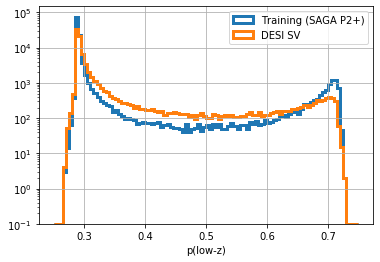

In [72]:
plt.hist(preds.softmax(1)[:,1].numpy(), bins=100, range=[0.25, 0.75], log=True, histtype='step', lw=3, label='Training (SAGA P2+)')
desi2.p_low_z_7_4.hist(bins=100, range=[0.25, 0.75], log=True, histtype='step', lw=3, label='DESI SV')
plt.xlabel('p(low-z)')
plt.legend()

## `6_4` model (no oversample)

### Train

In [73]:
loss_func = LabelSmoothingCrossEntropy(eps=0.1).cuda()

bs = 128
sz = 112
item_tfms = [Resize(sz)]


# no validation
df['kfold_split'] = False

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


In [74]:
dls = get_saga_dls(
    df, 
    label_column='low_z', 
    split_column='kfold_split',
    oversample=None, 
    PATH=PATH,
    seed=seed,
    bs=bs,
    item_tfms=item_tfms
)

model = xresnet18_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
learn = Learner(
    dls, model, 
    opt_func=ranger, 
    loss_func=loss_func,
    metrics=metrics,
)

learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.234551,None,None,None,None,None,01:55
1,0.228620,None,None,None,None,None,01:55
2,0.223378,None,None,None,None,None,01:55
3,0.222731,None,None,None,None,None,01:55
4,0.220254,None,None,None,None,None,01:55


/opt/anaconda3/envs/fastai2/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [77]:
preds, ys = learn.get_preds(0)
ps = preds.softmax(1)[:,1].numpy() > 0.5

confusion_matrix(ys, ps)

array([[109128,    310],
       [   954,   1596]])

In [76]:
# save model if it looks good
torch.save(
    learn.model.state_dict(), 
    PATH/'models/saga_s2+_6_4.pth'
)

### Predict DESI P2 cuts

In [75]:
test_dl = dls.test_dl(
    [f'{PATH}/images-legacy_desi-sv/{objid}.jpg' for objid in desi2.OBJID]
)

desi_preds, _ = learn.get_preds(dl=test_dl)

# save these predictions
desi2['p_low_z_6_4'] = desi_preds.softmax(1)[:,1].numpy()

### Examine plots (all objects)

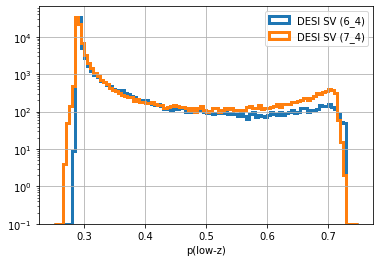

In [79]:
desi2.p_low_z_6_4.hist(bins=100, range=[0.25, 0.75], log=True, histtype='step', lw=3, label='DESI SV (6_4)')
desi2.p_low_z_7_4.hist(bins=100, range=[0.25, 0.75], log=True, histtype='step', lw=3, label='DESI SV (7_4)')

plt.xlabel('p(low-z)')
plt.legend()

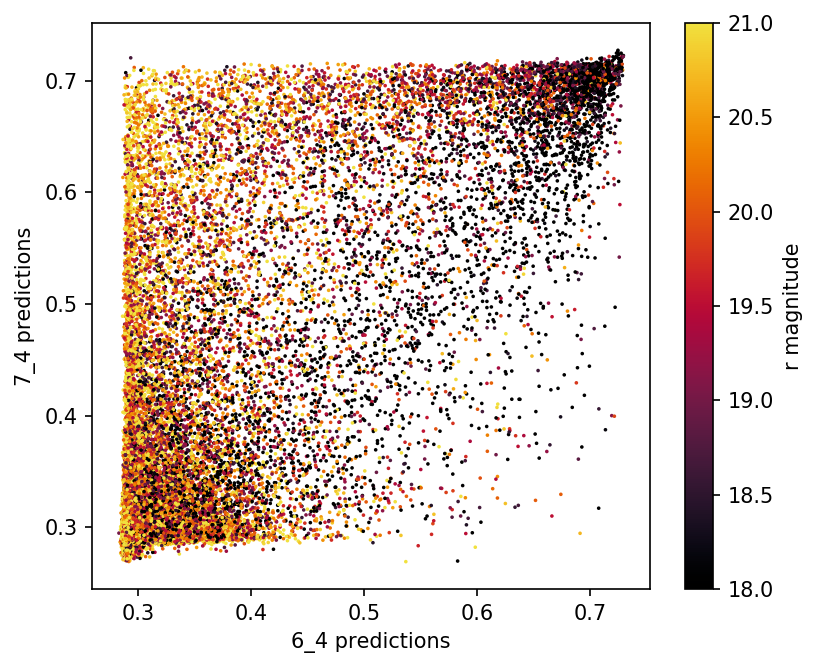

In [107]:
plt.figure(figsize=(6,5), dpi=150)
plt.scatter(desi2.p_low_z_6_4, desi2.p_low_z_7_4, c=desi2.r_mag, s=3, edgecolor='none', vmin=18, vmax=21, cmap='cmr.ember')
plt.xlabel('6_4 predictions')
plt.ylabel('7_4 predictions')
plt.colorbar(label='r magnitude');

### Predictions as function of magnitude

In [156]:
10**(-4)

0.0001

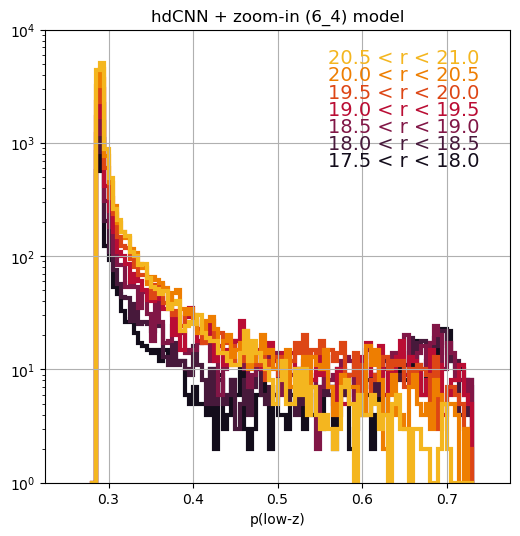

In [166]:
plt.figure(figsize=(6,6), dpi=100)
for r, color in zip(np.arange(18, 22, 0.5), cmr.ember(np.linspace(0.1, 0.9, 7))):
    desi2[(desi2.r_mag < r) & (desi2.r_mag >= r-0.5)].p_low_z_6_4.hist(bins=100, range=[0.25, 0.75], color=color, log=True, histtype='step', lw=3)
    plt.text(0.56, 1e4*2**(r-22), f'{r-0.5} < r < {r}', color=color, fontsize=14)
plt.xlabel('p(low-z)')
plt.ylim(1, 1e4)
                           
plt.title('hdCNN + zoom-in (6_4) model');

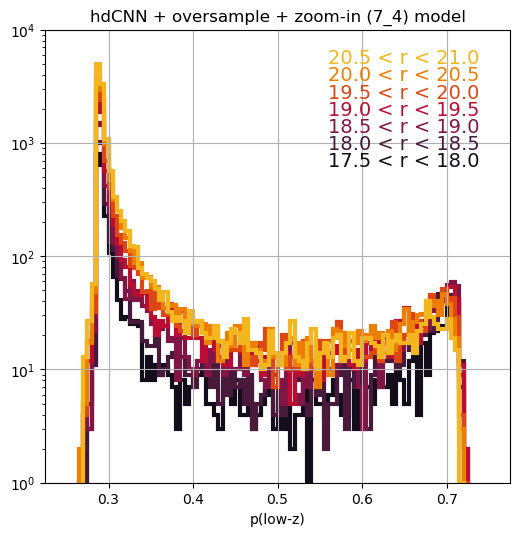

In [165]:
plt.figure(figsize=(6,6), dpi=100)
for r, color in zip(np.arange(18, 22, 0.5), cmr.ember(np.linspace(0.1, 0.9, 7))):
    desi2[(desi2.r_mag < r) & (desi2.r_mag >= r-0.5)].p_low_z_7_4.hist(bins=100, range=[0.25, 0.75], color=color, log=True, histtype='step', lw=3)
    plt.text(0.56, 1e4*2**(r-22), f'{r-0.5} < r < {r}', color=color, fontsize=14)
plt.xlabel('p(low-z)')
plt.ylim(1, 1e4)
plt.title('hdCNN + oversample + zoom-in (7_4) model');

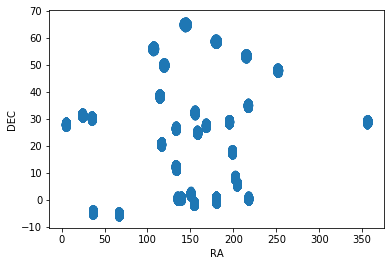

In [171]:
desi2.plot.scatter('RA', 'DEC')

## Number of predictions?

There are ~28 * 8 sq deg fields in the SV... or about 225 sq deg.

In [179]:
(
    sum((desi2.p_low_z_6_4 > 0.5) & (desi2.r_mag > 0)) / 225, 
    sum((desi2.p_low_z_6_4 > 0.5) & (desi2.r_mag > 19)) / 225,
    sum((desi2.p_low_z_6_4 > 0.5) & (desi2.r_mag > 19.5)) / 225,
    sum((desi2.p_low_z_6_4 > 0.5) & (desi2.r_mag > 20)) / 225
)

(19.88, 7.004444444444444, 4.942222222222222, 2.8444444444444446)

In [180]:
(
    sum((desi2.p_low_z_7_4 > 0.5) & (desi2.r_mag > 0)) / 225, 
    sum((desi2.p_low_z_7_4 > 0.5) & (desi2.r_mag > 19)) / 225,
    sum((desi2.p_low_z_7_4 > 0.5) & (desi2.r_mag > 19.5)) / 225,
    sum((desi2.p_low_z_7_4 > 0.5) & (desi2.r_mag > 20)) / 225
)

(34.382222222222225, 19.20888888888889, 15.186666666666667, 11.088888888888889)

# Save DESI (P2) predictions 

In [168]:
desi2[['OBJID', 'RA', 'DEC', 'r_mag', 'p_low_z_6_4', 'p_low_z_7_4']].to_csv(
    PATH/'results/desi-sv/desi_p2_preds.csv',
    index=False
)